In [15]:
%matplotlib inline

import matplotlib
import autograd.numpy as np
import matplotlib.pyplot as plt
import random
import math
from autograd import grad

def generateChevronData():
    xBounds = [-50, 50]
    yBounds = [-50, 50]
    totalPoints = 100
    
    points = []
    targets = []
    
    for i in range(0, totalPoints):
        x = random.randint(xBounds[0], xBounds[1])
        y = random.randint(yBounds[0], yBounds[1])
        
        if x >= y and x <= -y:
            points.append([x/50.0,y/50.0])
            targets.append(0)
        else:
            points.append([x/50.0,y/50.0])
            targets.append(1)
        
    return np.array(points), np.array(targets)
    
def plotScatter(points):
    xs = [x[0] for x in points]
    ys = [y[1] for y in points]
    
    plt.scatter(xs, ys)

In [28]:
def sigmoid(phi):
    return 1.0/(1.0 + np.exp(-phi))

def loss(weights):
    predictions = logisticPrediction(weights, points)
#     print(predictions)
    w = np.full((len(predictions)), np.log(1/2)) # CONSTANT
    r = responsibility(weights, points)
#     print(r)
    return -(1/len(points)) * np.sum( r * ((targets*np.log(predictions) + (1-targets)*np.log(1-predictions))) + (1-r) * w)

def logisticPrediction(weights, p):
    return np.array(list(map(lambda x: predict(weights, x), p))) 
    
def predict(weights, inputs):
    n = np.array([weights[0], weights[1]])
    i = np.array([weights[2] - inputs[0], weights[3] - inputs[1]])
    return sigmoid(np.dot(n, i))

def responsibility(weights, points):
    r = weights[4]
    a = np.array([weights[2], weights[3]])
    
    dif = np.array(list(map(lambda x: x - a, points)))
    s = np.array(list(map(lambda x: np.sum(np.power(x, 2)), dif)))
    d = np.sqrt(s)
    
#     return np.array(list(map(lambda x: 1 if x < np.absolute(r) else 0.1, d)))
    
#     return 1/(1 + np.power(np.e, (-(d - r))))
    t = 1 - f(d, r)
#     print(t)
    return t

def f(d, r):
    return np.maximum(d - r, 0)/(np.abs(d - r) + 0.1)

In [29]:
# def computeGradient(weights, example, target):
#     prediction = predict(weights, example)
#     r = responsibility(weights, [example])[0]
#     dE_dO = computeErrorDifferential(r, prediction, target)
#     dE_dr = computeResponsibilityDifferential(weights, example)
    
#     dO_dZ = prediction * (1-prediction)
    
# #     dZ_d0 = example[0]
#     dZ_d1 = (weights[2] - example[0])
#     dZ_d2 = (weights[3] - example[1])
#     dZ_d3 = weights[0]
#     dZ_d4 = weights[1]
    
#     dE_dZ = dE_dO * dO_dZ
    
#     grad = np.zeros(len(weights))#[0.0, 0.0, 0.0]
# #     grad[0] = dZ_d0 * dE_dZ
#     grad[0] = dZ_d1 * dE_dZ
#     grad[1] = dZ_d2 * dE_dZ
#     grad[2] = dZ_d3 * dE_dZ
#     grad[3] = dZ_d4 * dE_dZ
#     grad[4] = -dE_dr * ((target*np.log(prediction) + (1-target)*np.log(1-prediction)) - np.log(1/2))
# #     print(((target*np.log(prediction) + (1-target)*np.log(1-prediction))))
    
#     return grad

# def computeErrorDifferential(r, prediction, target):
#     return -r * (target - prediction)/(prediction - prediction**2)

# def computeResponsibilityDifferential(weights, example):
#     r = weights[4]
#     a = np.array([weights[2], weights[3]])
    
#     dif = example - a
#     s = np.sum(np.power(dif, 2))
#     d = np.sqrt(s)
    
#     return (10 * np.power(np.e, (d + r)))/np.power(np.power(np.e, 10*d) + np.power(np.e, 10*r), 2)

In [30]:
def trainBoundaryHunter():
    weights = np.array([0.0, 0.0, 0.0, 0.0, 0.3])
    gradient = grad(loss)
    print("Initial Loss: ", loss(weights))
    for i in range(0, 10000):
        g = gradient(weights)
        
        if i % 1000 == 0:
            print("Loss [i = " + str(i) + "]: " + str(loss(weights)))
            print(weights)
            checkGrad(0.00001, 0.0001, weights, g)
        
#         weights = computeStep(weights)
        weights -= 0.01 * g
            
    print("Trained Loss: ", loss(weights))    
    print("Weights: ", weights)
    return weights

# def computeStep(weights):
#     totalG = np.zeros(len(weights))
#     totalE = 0
#     for i in range(0, len(points)):
#         g = computeGradient(weights, points[i], targets[i])
#         totalG += g     
        
#     totalG = totalG * (1/len(points))
    
#     grad = checkGrad(0.00001, 0.00001, weights)
#     weights -= grad * 0.01
#     return weights

def checkGrad(pterb, threshold, weights, g):
    grad = np.zeros(len(weights))
    for i in range(0, len(weights)):
        p = np.zeros(len(weights))
        p[i] = pterb
        
        lossBefore = loss(weights)
        lossAfter = loss(weights + p)
        
        grad[i] = (lossAfter - lossBefore)/pterb
        

    return grad

    dif = np.absolute(computedGrad - grad)
    for d in dif:
        if d > threshold:
            print("ERROR")
    

Type 0:  35
Type 1:  65
Initial Loss:  0.69314718056
Loss [i = 0]: 0.69314718056
[ 0.   0.   0.   0.   0.3]
Loss [i = 1000]: 0.675161584975
[-0.04812215 -0.36845943  0.0084891  -0.08472712  0.44598983]
Loss [i = 2000]: 0.484498243876
[-0.18067838 -1.31887895 -0.15189185 -0.20675036  1.2050308 ]
Loss [i = 3000]: 0.360899628372
[-0.38699145 -2.21001096 -0.20913397 -0.46818709  1.59339862]
Loss [i = 4000]: 0.326856582424
[-0.48241824 -2.78162701 -0.20401688 -0.45131717  1.59796803]
Loss [i = 5000]: 0.308190717196
[-0.56824637 -3.20347958 -0.20110695 -0.43468756  1.59796803]
Loss [i = 6000]: 0.296596572003
[-0.64448968 -3.53454446 -0.19946502 -0.42554746  1.59796803]
Loss [i = 7000]: 0.288820370032
[-0.71192317 -3.80466678 -0.19839296 -0.41973998  1.59796803]
Loss [i = 8000]: 0.283319492431
[-0.77179159 -4.03114295 -0.19762891 -0.41570177  1.59796803]
Loss [i = 9000]: 0.279273629747
[-0.82523688 -4.22485561 -0.19705172 -0.41271642  1.59796803]
Trained Loss:  0.276208446155
Weights:  [-0.87

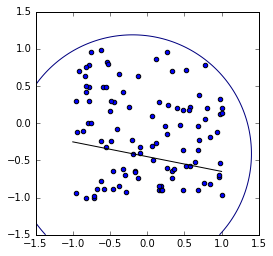

In [31]:
random.seed(1234)
points, targets = generateChevronData()

plt.axis([-1.5, 1.5, -1.5, 1.5])

# Plot points on graph
c1 = []
c2 = []

for i in range(0, len(points)):
    if targets[i] == 0:
        c1.append(points[i])
    else:
        c2.append(points[i])

print("Type 0: ", len(c1))
print("Type 1: ", len(c2))
        
plotScatter(c1)
plotScatter(c2)

weights = trainBoundaryHunter()

# plt.scatter(weights[1], weights[2])
plt.scatter(weights[2], weights[3])

n = np.array([weights[0] * weights[2] + weights[1] * weights[3], 
              -weights[0], 
              -weights[1]])

byas = -1 * n[0]/n[2]
Xcoef = -1 * n[1]/n[2]

x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 1.5, 500)
X, Y = np.meshgrid(x,y)
F = ((X - weights[2]))**2 + ((Y - weights[3]))**2 - weights[4]**2
plt.contour(X,Y,F,[0])

print()
print(n)
print("\nLine")
print("B: " + str(byas))
print("XCoef: " + str(Xcoef))

plt.plot([-1.0, 1.0], [-1*Xcoef + byas, Xcoef + byas], 'k-')
plt.gca().set_aspect('equal')

plt.show()